In [7]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, log_loss, mean_squared_error
from sklearn.preprocessing import LabelBinarizer
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

In [8]:
# Laden der Daten
data_path = 'train_with_feature_test.csv'
data = pd.read_csv(data_path)
data_cleaned = data.dropna()

C:\Users\Tobia\AppData\Local\Temp\ipykernel_6648\1923731555.py:3: DtypeWarning: Columns (1,2,3,4,5,6,7,10,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


In [9]:
# Spalten für das Modell (vereinfachte Auswahl für die Demonstration)
feature_columns = ['DayOfWeek', 'PdDistrict', 'X', 'Y', 'Min.TemperatureF', 'Mean.TemperatureF', 'Max.TemperatureF', 'Mean.Humidity','Events', 'season']
# Zielvariable
target_column = 'Category'

In [10]:
# Identifizieren der kategorischen und numerischen Variablen
categorical_features = [col for col in feature_columns if data_cleaned[col].dtype == 'object']
numerical_features = [col for col in feature_columns if col not in categorical_features]

# Vorbereiten des ColumnTransformers, um OneHotEncoding nur auf kategorischen Variablen anzuwenden
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_features)
    ]
)

# Vorbereiten der Features und Zielvariable
X = data_cleaned[feature_columns]
y = data_cleaned[target_column]

# Anwenden des Preprocessors
X_processed = preprocessor.fit_transform(X)

# Umwandlung des Ergebnisses zurück in ein DataFrame
# Für die kategorischen Features Namen aus dem Encoder extrahieren
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
# Gesamtnamen der Features nach der Verarbeitung
all_feature_names = np.concatenate([numerical_features, encoded_feature_names])

# Erstellen des finalen DataFrames
X_final = pd.DataFrame(X_processed, columns=all_feature_names)

X_final.head()  # Zeigt die ersten Zeilen des verarbeiteten DataFrames


C:\Users\Tobia\PycharmProjects\SF-CrimePredict\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,X,Y,Min.TemperatureF,Mean.TemperatureF,Max.TemperatureF,Mean.Humidity,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,...,Events_Clear,Events_Fog,Events_Fog-Rain,Events_Rain,Events_Rain-Thunderstorm,Events_Thunderstorm,season_Autumn,season_Spring,season_Summer,season_Winter
0,-122.426995,37.800873,52.0,59.0,65.0,61.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-122.438738,37.771541,52.0,59.0,65.0,61.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-122.403252,37.713431,52.0,59.0,65.0,61.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-122.423327,37.725138,52.0,59.0,65.0,61.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-122.371274,37.727564,52.0,59.0,65.0,61.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [11]:
# Initialisieren des LabelEncoders
label_encoder = LabelEncoder()


# Aufteilung der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Initialisieren des XGBoost Classifiers
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Anpassen des Encoders an die gesamten Labels
# Hinweis: Hier nehmen wir an, dass `data[target_column]` alle möglichen Labels enthält.
label_encoder.fit(data[target_column])

# Transformieren der Zielvariablen in Trainings- und Testdatensätzen in numerische Werte
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

# Training des Classifiers
xgb_clf.fit(X_train, y_train)

# Vorhersagen auf dem Testset
y_pred = xgb_clf.predict(X_test)

# Vorhersagen der Wahrscheinlichkeiten für das Testset, um ROC-AUC und Log Loss zu berechnen
y_pred_proba = xgb_clf.predict_proba(X_test)

# Berechnung der verschiedenen Metriken
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' berücksichtigt Label-Unausgewogenheit
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# ROC-AUC Score erfordert binarisierte Labels für Mehrklassenklassifikation
lb = LabelBinarizer()
lb.fit(y_test)
y_test_binarized = lb.transform(y_test)
y_pred_binarized = lb.transform(y_pred)

roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovo', average='weighted')
logloss = log_loss(y_test, y_pred_proba)


# Ausgabe der Metriken
print(f"Genauigkeit (Accuracy): {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Präzision (Precision): {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Log Loss: {logloss:.4f}")

Genauigkeit (Accuracy): 0.5578
F1-Score: 0.4831
Präzision (Precision): 0.5037
Recall: 0.5578
ROC-AUC Score: 0.7398
Log Loss: 1.1615


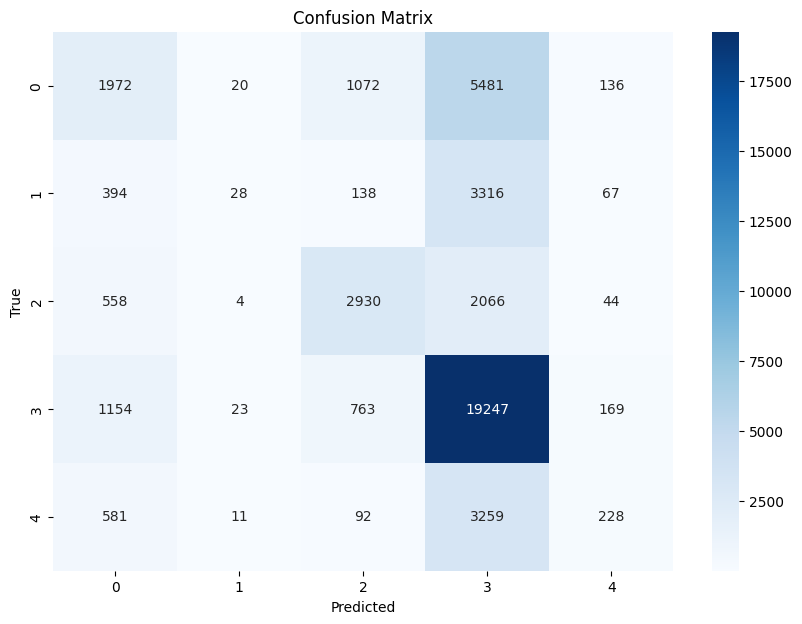

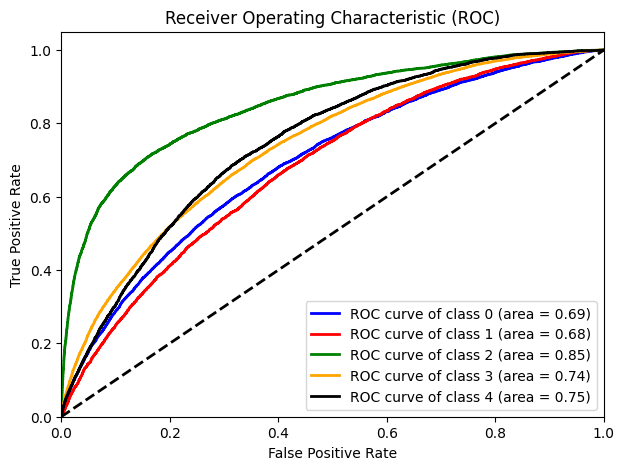

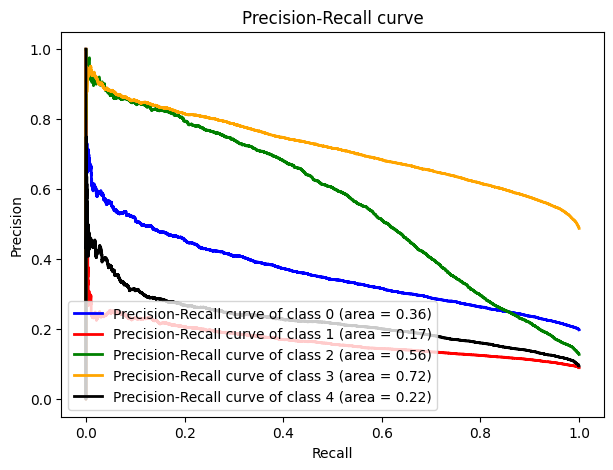

In [20]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Die Confusion Matrix ist eine grundlegende und sehr informative Visualisierung,
# die zeigt, wie gut das Modell die verschiedenen Klassen unterscheidet.
# Sie gibt die Anzahl der korrekten und falschen Vorhersagen für jede Klasse an und hilft,
# die Bereiche zu identifizieren, in denen das Modell möglicherweise verbessert werden muss

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Die Receiver Operating Characteristic (ROC)-Kurve und die Area Under the Curve (AUC)
# sind besonders nützlich für binäre Klassifizierungsprobleme.
# Sie können auch für Mehrklassenprobleme angepasst werden,
# indem man die One-vs-All-Strategie für jede Klasse anwendet.
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Farben für die verschiedenen Klassen
colors = cycle(['blue', 'red', 'green', 'orange', 'black'])

# Plotten der ROC-Kurve für jede Klasse
plt.figure(figsize=(7, 5))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Berechnung für jede Klasse
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i],
                                                        y_pred_proba[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])

# Die Precision-Recall-Kurve ist eine weitere nützliche Visualisierung, 
# besonders in Situationen, in denen die Klassen stark unausgeglichen sind. 
# Sie zeigt das Verhältnis von Precision (Präzision) und Recall (Sensitivität) für verschiedene Schwellenwerte.
plt.figure(figsize=(7, 5))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-Recall curve of class {0} (area = {1:0.2f})'
             ''.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()


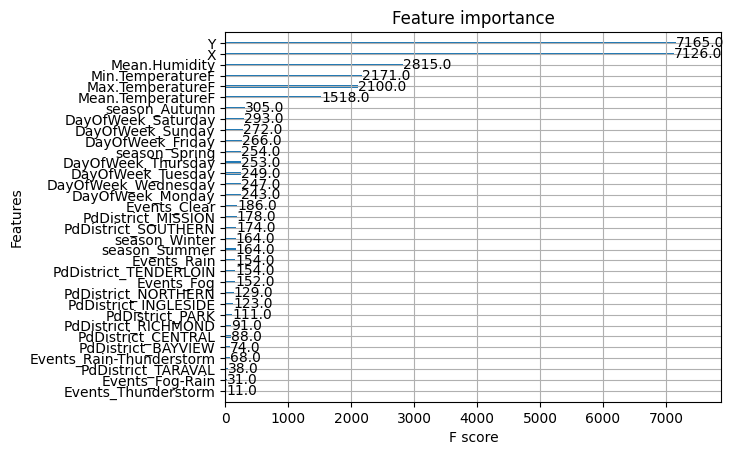

In [19]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Visualisierung der Feature Importance
plot_importance(xgb_clf)
plt.show()
